# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, и проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные - недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе - 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Описание данных
Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv
- /datasets/geo_data_1.csv
- /datasets/geo_data_2.csv

Признаки:
- **id** - уникальный идентификатор скважины;
- **f0**, **f1**, **f2** - три признака точек (неважно, что они означают, но сами признаки значимы).

Целевой признак модели - **product** - объём запасов в скважине (тыс. баррелей).

## Импорт модулей

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Загрузка и подготовка данных

### Чтение данных

In [2]:
geo_data = list()

for i in range(3):
    try:
        geo_data.append(pd.read_csv(f'/datasets/geo_data_{i}.csv'))
    except:
        geo_data.append(pd.read_csv(f'https://code.s3.yandex.net/datasets/geo_data_{i}.csv'))

### Знакомстово с данными
Для каждого региона выведем первые 10 строк, общюю информацию о датафрейме и описательные статистики. Также проверим данные для каждого региона на наличие дубликатов.

In [3]:
for i, df in enumerate(geo_data):
    
    print(f'Регион {i+1}')
    
    print('Первые 10 строк датафрейма:')
    display(df.head(10))
    
    print('Информация о столбцах:')
    df.info()
    
    print('\nОписательные статистики:')
    display(df.describe())
    
    if df.duplicated().any():
        print('Обнаружены дубликаты!')
    else:
        print('Дубликатов не обнаружено.')
    
    print('\n')

Регион 1
Первые 10 строк датафрейма:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Описательные статистики:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Дубликатов не обнаружено.


Регион 2
Первые 10 строк датафрейма:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Описательные статистики:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Дубликатов не обнаружено.


Регион 3
Первые 10 строк датафрейма:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Описательные статистики:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Дубликатов не обнаружено.




Данные не содержат пропусков. Признаки имеют правильные типы данных. Признак `id` - уникальный идентификатор скважины, будем отбрасывать.

### Разделение данных на тренировочный и валидационный наборы
Разделим данные для каждого региона на тренировочный и валидационный наборы.

In [4]:
def split_datasets(df_list, random_state=42):
    '''Делит данные на тренировочный и валидационный наборы.'''
    
    X_train_list = list()
    y_train_list = list()
    X_valid_list = list()
    y_valid_list = list()
    
    
    for df in df_list:
        
        X = df.drop(columns='product')
        y = df['product'].copy()
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
        
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_valid_list.append(X_valid)
        y_valid_list.append(y_valid)
        
    return X_train_list, y_train_list, X_valid_list, y_valid_list

In [5]:
X_train_list, y_train_list, X_valid_list, y_valid_list = split_datasets(geo_data)

### Исследование данных
Для каждого региона будем выводить диаграммы размаха и гистограммы для каждого столбца, диаграммы разброса и матрицу корреляции. Исследования будем выполнять только на тестовом наборе.

Напишем функцию, которая будет выводить на экран диаграмму размаха и гистограмму для каждого столбца из набора данных.

In [6]:
def explore_data(df, dataset_name):
    '''Выводит на экран диаграмму размаха и гистограмму для кажого столбца.'''
    
    for col in df: 
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 3]))
        df.plot(y=col, kind='box', ax=ax0, grid=True)
        df.plot(y=col, kind='hist', bins=30, ax=ax1, grid=True, legend=False)
        plt.suptitle(f'{dataset_name}: {col}')
        plt.show()

Напишем функцию, которая будет выводить на экран матрицу корреляции для каждого набора данных.

In [7]:
def plot_corr_matrix(df):
    '''Выводит на экран матрицу корреляции.'''
    
    corr = df.corr()
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    f, ax = plt.subplots(figsize=(5, 5))
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr,
                 mask=mask,
                 cmap=cmap,
                 annot=True,
                 vmax=1,
                 vmin=-1,
                 center=0,
                 square=True,
                 linewidths=2.0,
                 cbar_kws={"shrink": 0.5},
                 ax=ax
                )
    
    ax.set_title('Матрица корреляции')
    
    plt.show()

Исследуем наборы данных.

Регион 1


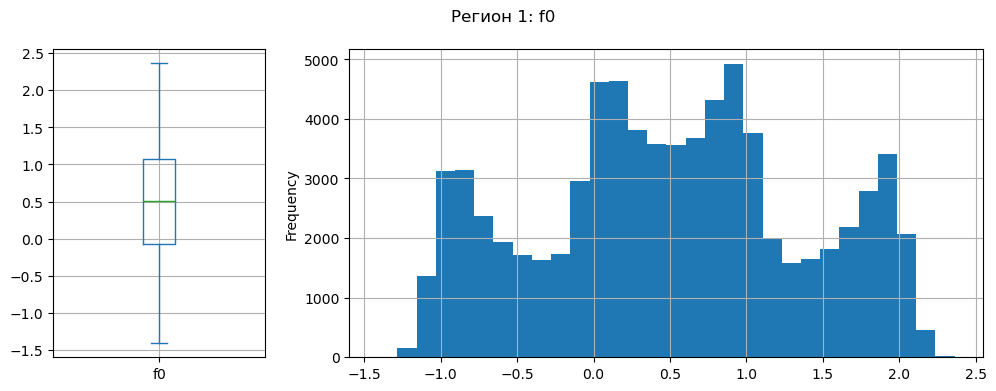

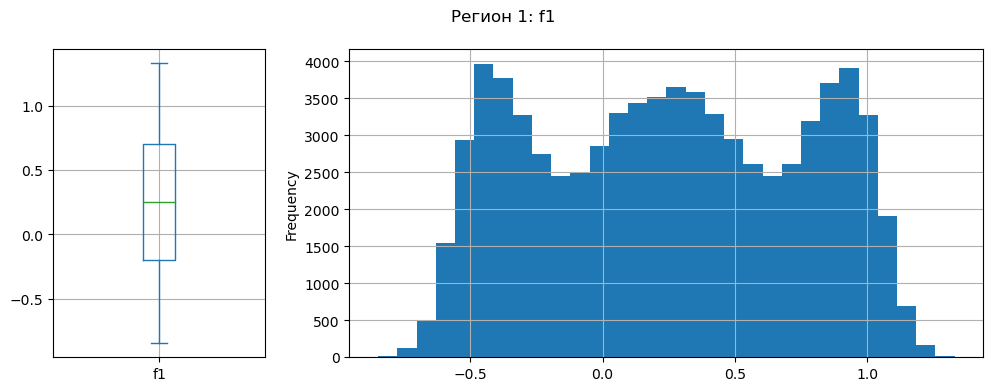

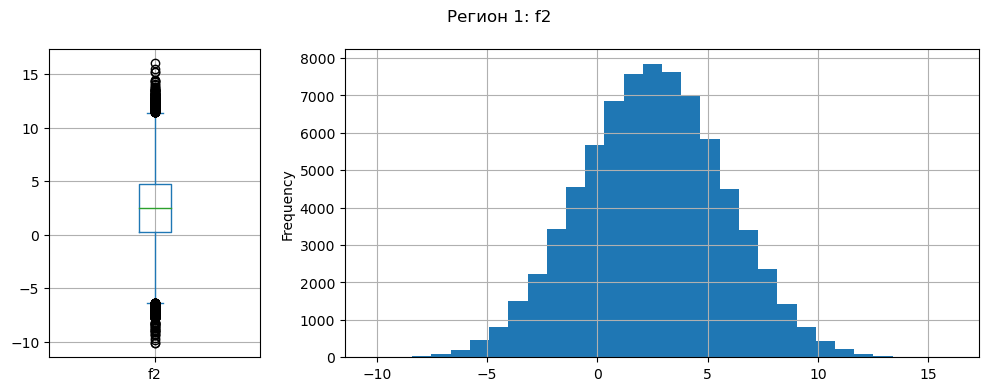

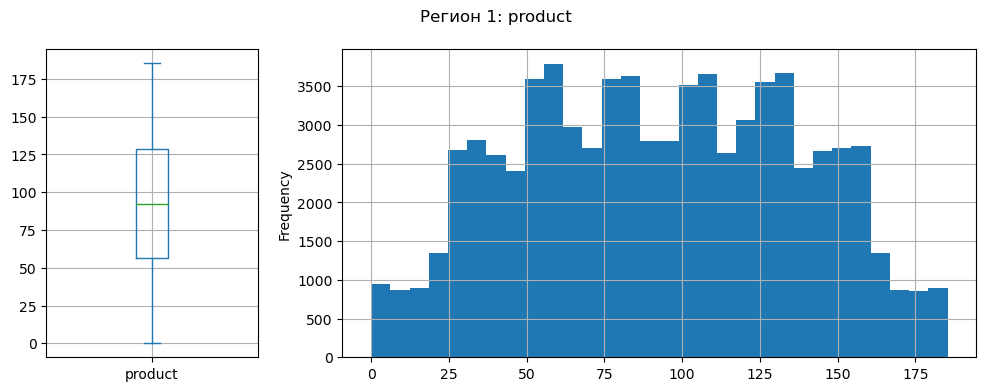

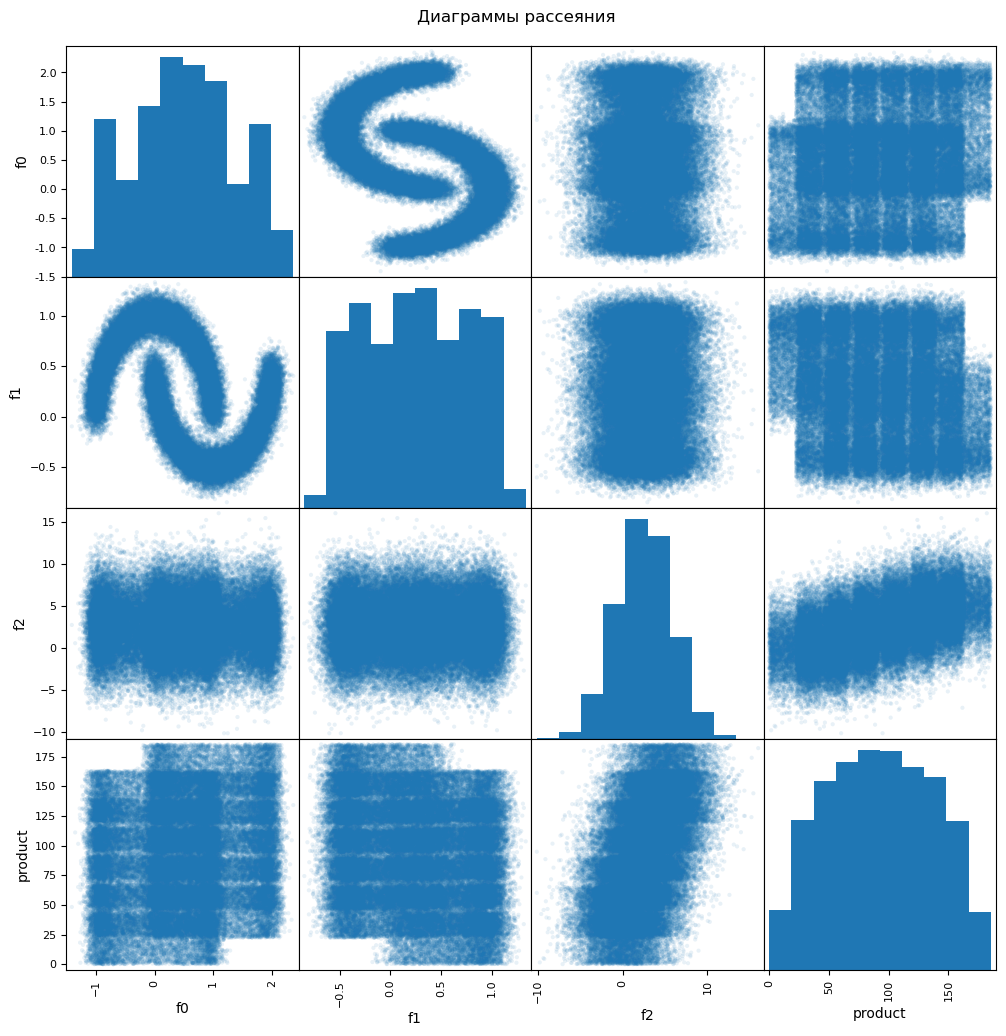

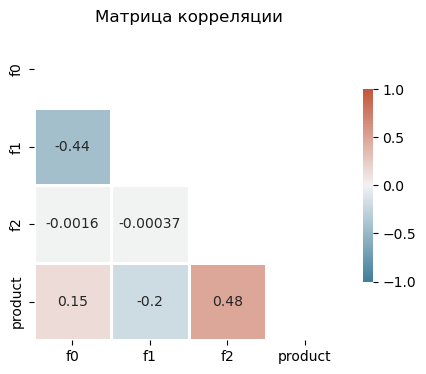




Регион 2


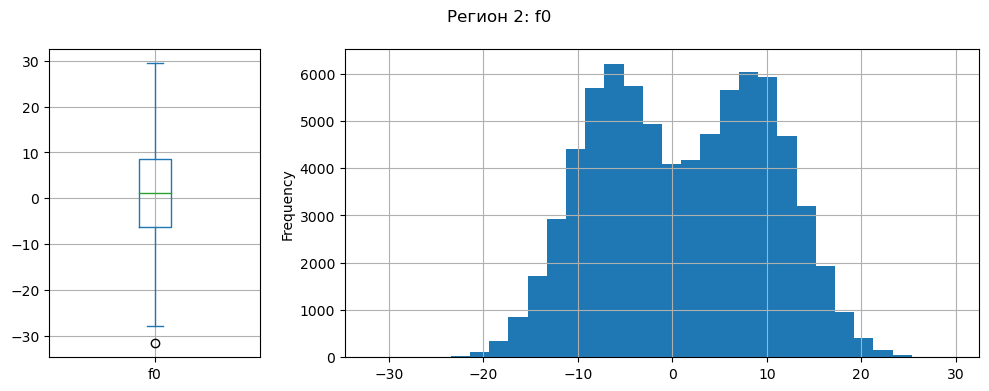

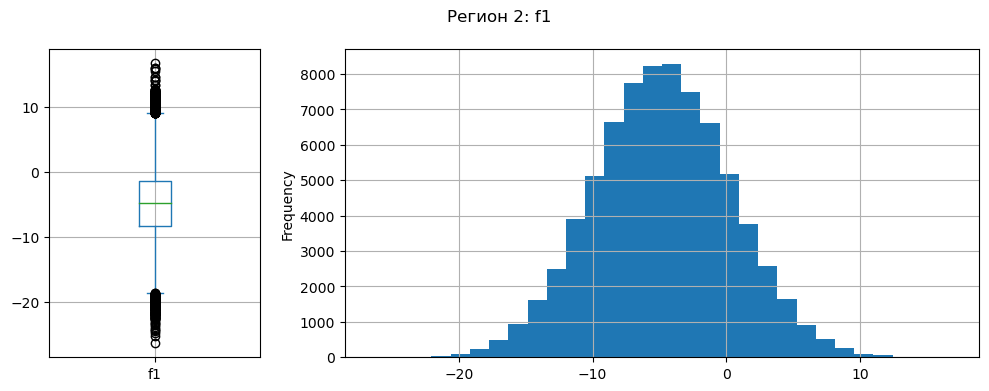

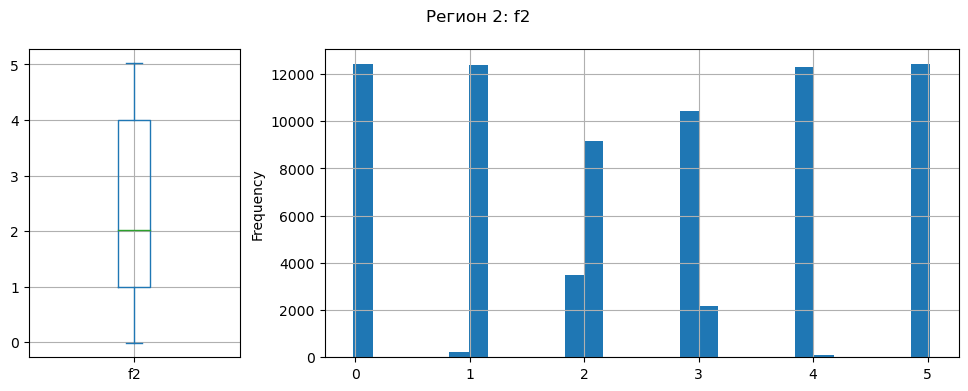

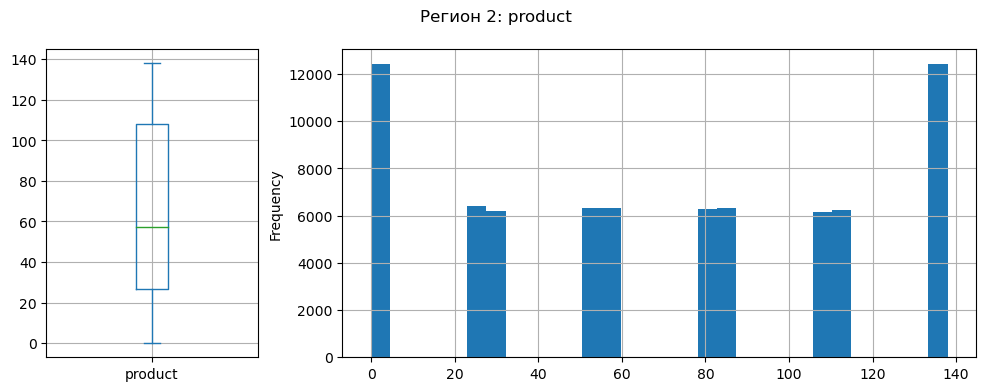

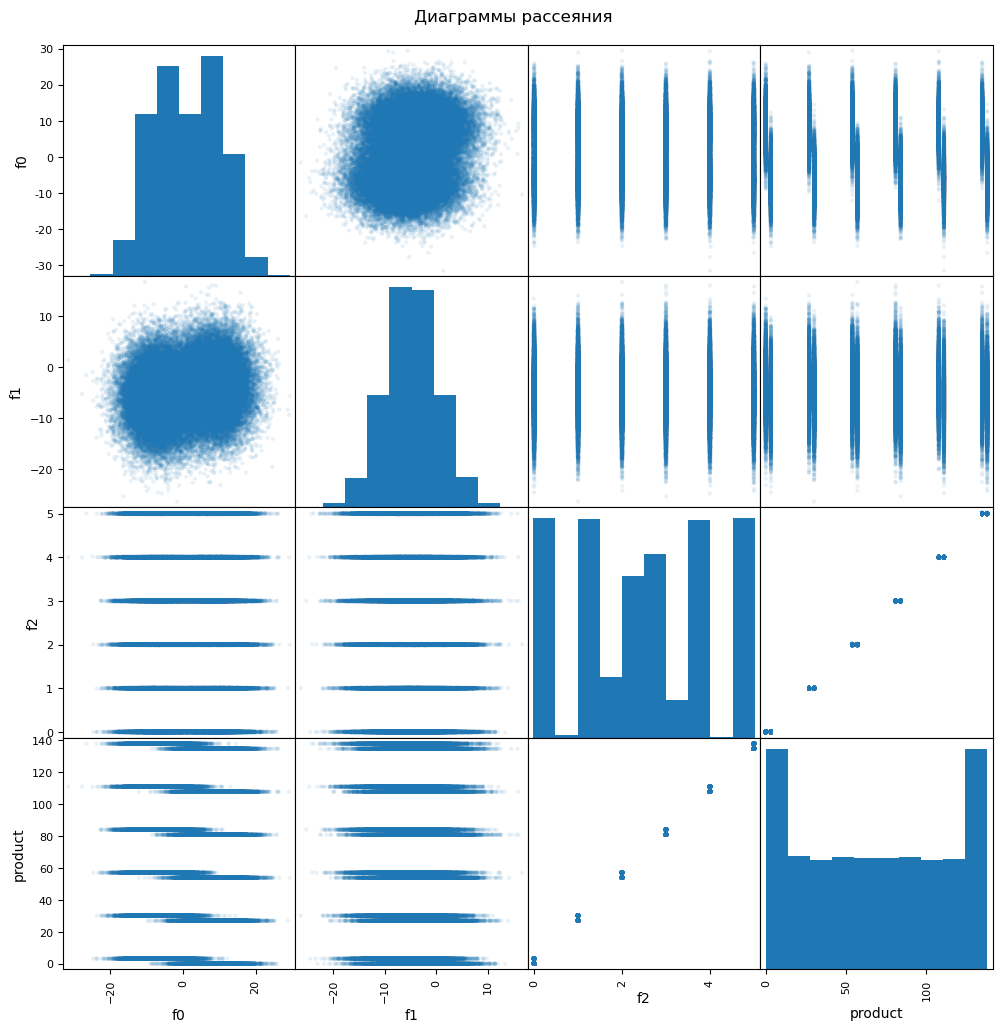

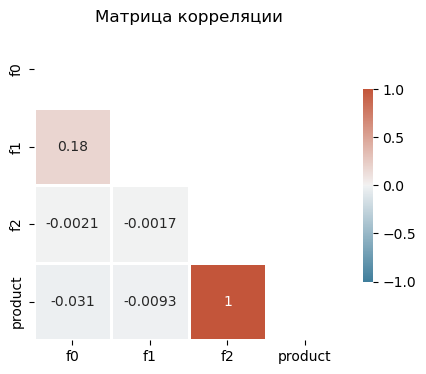




Регион 3


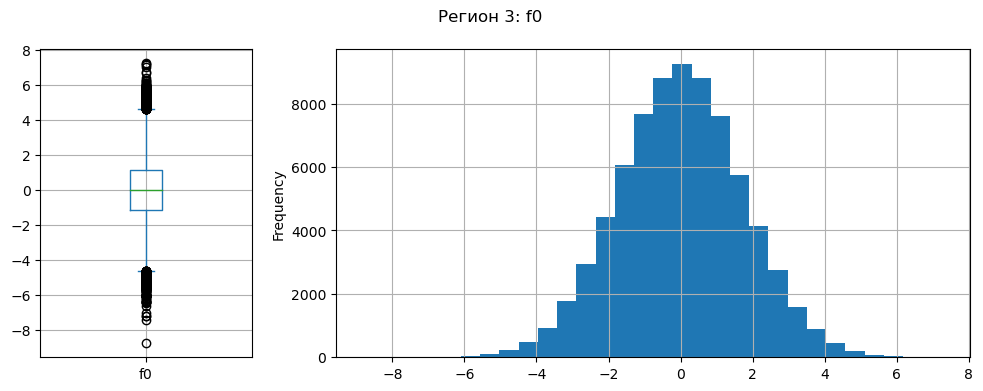

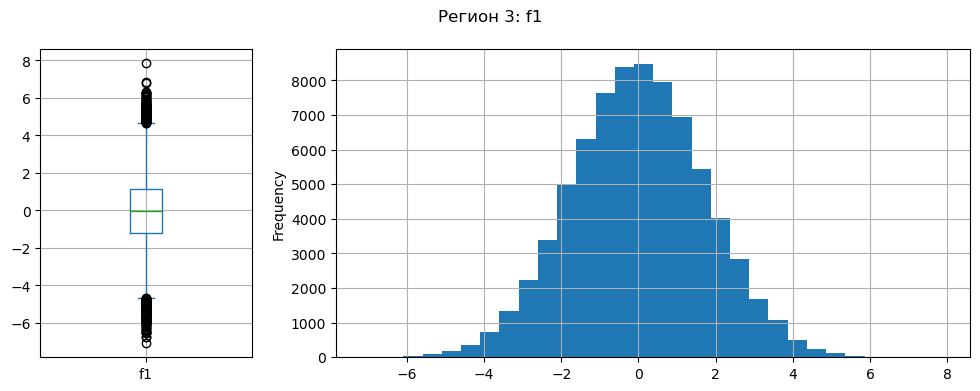

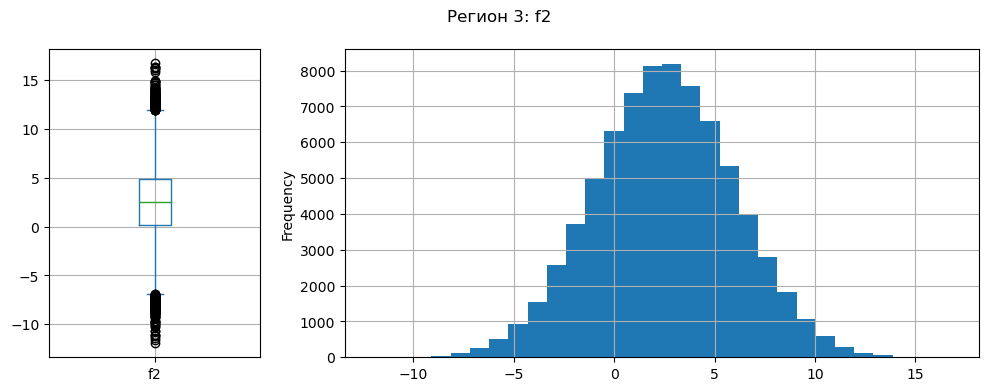

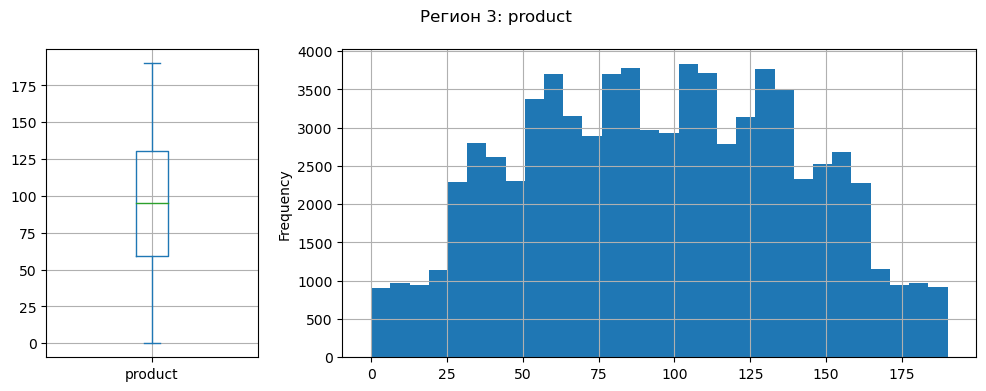

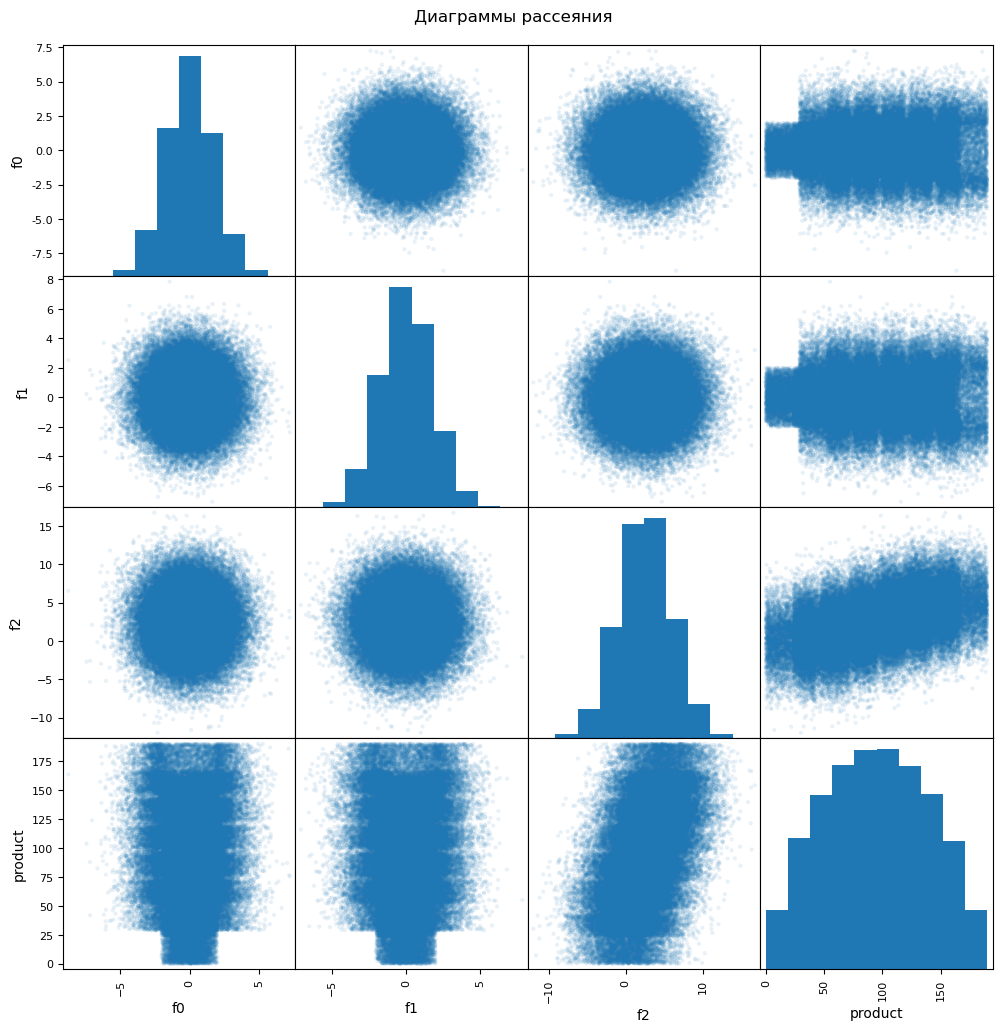

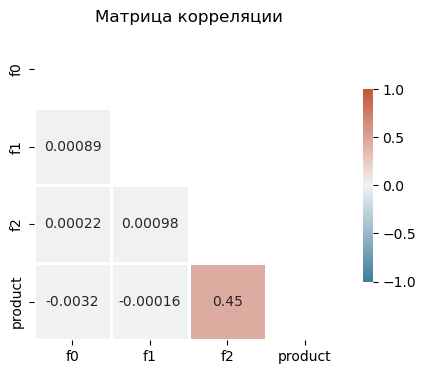

In [8]:
for i, data_list in enumerate(zip(X_train_list, y_train_list)):
    
    df = pd.concat(data_list, axis='columns').drop(columns='id')
    
    print(f'Регион {i+1}')
    
    explore_data(df, f'Регион {i+1}')
    
    print()
    
    scatter_matrix(df, figsize=(12, 12), alpha=0.1)
    plt.suptitle('Диаграммы рассеяния', y=0.91)
    plt.show()
    
    print()
    
    plot_corr_matrix(df)


    print('\n\n')

В данных замечены следующие особенности:
- Признаки имеют разный масштаб.
- В данных для каждого региона есть признаки, которые содержат несколько мод.
- Формы распределений значений нектороых признаков отличаются от формы нормального распределения (распределения либо не похожи на нормальное, либо имеют "тяжёлые хвосты").
- На диаграммах размаха некоторых признаков отмечены выбросы, тем не менее, это не далеко стоящие отдельные точки, а достаточно плотные группы точек, поэтому не будем их удалять.
- Связь между признаками `f0` и `f1` для региона 1 явно нелинейная, при этом, данные признаки показывают несущественную отрицательную корреляцию (-0.44).
- Признаки `f0`, `f1`, `f2` не коррелируют между собой для всех регионов (кроме признаков `f0` и `f1` для региона 1, о которых было сказано в предыдущем пункте).
- Лучшую корреляцию с целевым признаком `product` показывает признак `f2`.
- Для региона 2 между целевым признаком `product` и признаком `f2` линейная зависимость (коэффициент корреляции равен 1).

Таким образом, обработка данных будет состоять из двух шагов:
1. Отбросить признак `id`.
1. Выполнить стандартизацию.

### Обработка данных и модель
Напишем конвейер, который будет содержать необходимые этапы обработки данных и модель линейной регрессии.

In [9]:
pipeline = Pipeline([
    ('drop_id', ColumnTransformer([('drop', 'drop', 'id')], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

## Обучение и проверка модели

Обучим модели и проверим их работу на валидационном наборе данных. Также для каждого региона будем предсказывать средний запас сырья.

In [10]:
y_pred_list = list()

for i, (X_train, y_train, X_valid) in enumerate(zip(X_train_list, y_train_list, X_valid_list)):
    
    y_pred_list.append(
        pipeline.fit(X_train, y_train).predict(X_valid)
    )

    print(f'Средний запас предсказанного сырья в регионе {i+1} = {y_pred_list[-1].mean():.3f} тыс. барелей.')
    print(f'RMSE модели для региона {i+1} = {mean_squared_error(y_valid_list[i], y_pred_list[-1], squared=False):.3f} тыс. барелей.')
    print()

Средний запас предсказанного сырья в регионе 1 = 92.399 тыс. барелей.
RMSE модели для региона 1 = 37.757 тыс. барелей.

Средний запас предсказанного сырья в регионе 2 = 68.713 тыс. барелей.
RMSE модели для региона 2 = 0.890 тыс. барелей.

Средний запас предсказанного сырья в регионе 3 = 94.771 тыс. барелей.
RMSE модели для региона 3 = 40.146 тыс. барелей.



**Выводы:**
1. Самые точные предсказания удалось получить для региона 2, что связано с наличием линейной зависимости между целевым признаком `product` и признаком `f2` (коэффициент корреляции равен 1) для данного региона.
2. Для регионов 1 и 3 корень из среднеквадратической ошибки для предсказания запасов сырья примерно одинаковый (примерно 38 и 40 тыс. барелей соответственно).
3. Самый высокий редний запас предсказанного сырья в регионе 3 (примерно 95 тыс. баррелей), самый низкий - в регионе 2 (примерно 69 тыс. баррелей).

## Подготовка к расчёту прибыли
Сохраним все ключевые значения для расчётов в отдельных переменных:
- `n_points` - количество точек, исследуемых при разведке региона;
- `n_best` - количество точек, выбранных для разработки;
- `budget` - бюджет на разработку скважин в регионе;
- `income_barrel` - стоимость 1 барелля сырья;
- `income_product` - доход с единицы продукта, равной 1000 баррелей;
- `loss_probability` - максимально допустимая вероятность убытков.

In [11]:
n_points = 500
n_best = 200
budget = 10 ** 10
income_barrel = 450
income_product = 450_000
marginal_loss_probability = 0.025

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [12]:
min_volume = budget / n_best / income_product

print(f'Объём сырья, достаточный для безубыточной разработки скважины: {min_volume:.3f} тыс. баррелей.')

Объём сырья, достаточный для безубыточной разработки скважины: 111.111 тыс. баррелей.


Объём сырья, достаточный для безубыточной разработки скважины, выше среднего предсказанного запаса сырья в каждом регионе. Таким образом, разработка скважин может оказаться убыточной. 

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [13]:
def get_income(y_pred, y_valid):
    '''Расчёт прибыли по выбранным скважинам и придсказаниями модели.'''
    
    sorted_indeces = np.argsort(y_pred)
    
    prod = y_valid[sorted_indeces[-n_best:]].sum()
    
    return prod * income_product - budget

Чтобы расчитать риски и прибыль для каждого региона применим технику *Bootstrap*. Данная техника предполагает случайные выбоки, а на данном этапе нам нужна повторяемость результатов, поэтому инициализируем генератор случайных чисел следующим образом:

In [14]:
rng = np.random.default_rng(42)

Напишем функцию, которая для каждого региона будет генерировать 1000 выборок и на этих выборках вычислять прибыль, затем, будет строить гистограмму распределения прибыли, вычислять средню прибыль, её 95%-й доверительный интервал и вероятность убытков (отрицательной прибыли).

In [15]:
def bootstrap(y_pred, y_valid, rng_gen, n_samples=1000):
    '''Генерирует 1000 выборок и на этих выборках вычисляем прибыль, 
    затем, строит гистограмму распределения прибыли, вычисляет средню 
    прибыль, её 95%-й доверительный интервал и вероятность убытков 
    (отрицательной прибыли)'''
    
    income_arr = np.zeros(shape=n_samples)
    
    for i in range(n_samples):
        sampled_indices = rng_gen.choice(np.arange(y_pred.shape[0]), 
                                         size=n_points, 
                                         replace=True
                                        )
        income_arr[i] = get_income(y_pred[sampled_indices], y_valid[sampled_indices])
    
    
    print(f'Средняя прибыль равна {income_arr.mean() / 10 ** 6 :.3f} млн. рублей')
    
    
    low = np.quantile(income_arr, 0.025) / 10 ** 6
    high = np.quantile(income_arr, 0.975) / 10 ** 6
    print(f'95%-й доверительный интервал для прибыли равен [{low:.3f}, {high:.3f}] млн. рублей')
    
    
    loss_probability = (income_arr < 0).mean()
    print(f'Вероятность получить убыток составляет {loss_probability:.2%}')
    
    if loss_probability < marginal_loss_probability:
        print('Регион подходит!')
    else:
        print('Регион не подходит!')
    
        
    sns.displot(x=income_arr / 10 ** 6, stat='density')
    
    plt.xlabel('Прибыль, млн. рублей')
    plt.ylabel('Плотность вероятности')
    plt.title('Распределение прибыли')
    
    plt.show()

Регион 1
Средняя прибыль равна 413.353 млн. рублей
95%-й доверительный интервал для прибыли равен [-94.462, 928.204] млн. рублей
Вероятность получить убыток составляет 4.50%
Регион не подходит!


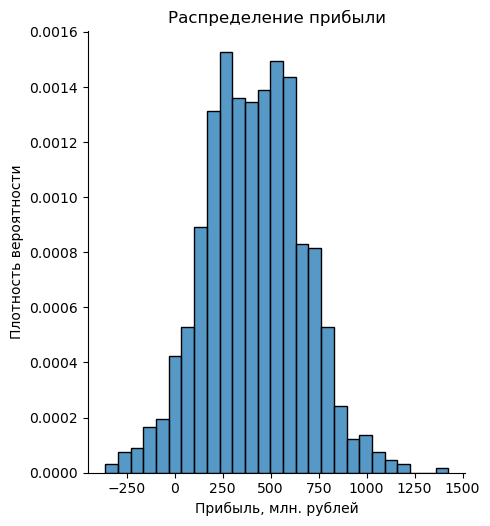


Регион 2
Средняя прибыль равна 435.423 млн. рублей
95%-й доверительный интервал для прибыли равен [38.751, 840.196] млн. рублей
Вероятность получить убыток составляет 1.40%
Регион подходит!


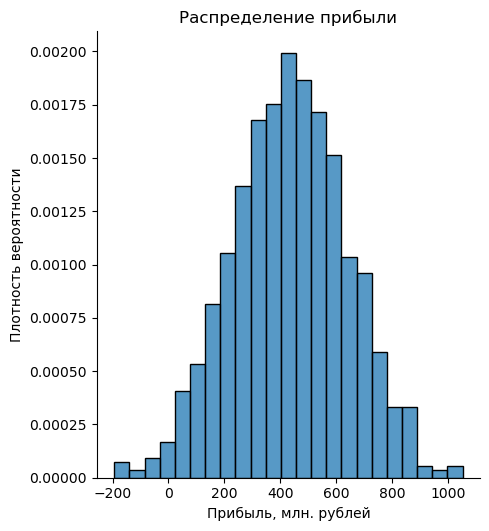


Регион 3
Средняя прибыль равна 389.005 млн. рублей
95%-й доверительный интервал для прибыли равен [-99.311, 892.985] млн. рублей
Вероятность получить убыток составляет 6.60%
Регион не подходит!


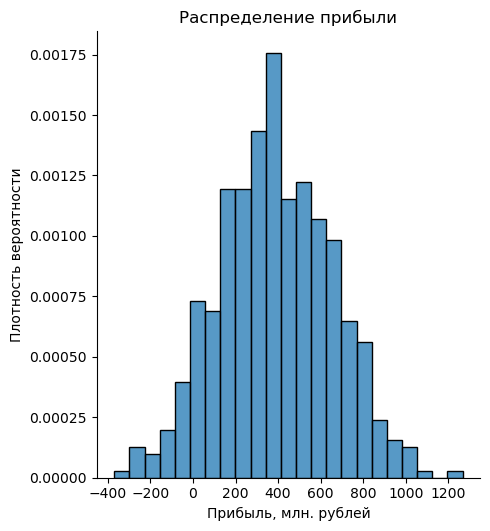

In [16]:
for i, (y_pred, y_valid) in enumerate(zip(y_pred_list, y_valid_list)):
    print(f'Регион {i + 1}')
    bootstrap(y_pred, y_valid.to_numpy(), rng_gen=rng, n_samples=1000)
    print()

Таким образом, для разработки подходит только регион 2, так как только для него вероятность убытков ниже 2.5%.

Регион 2 имеет следующие параметры:
- Средняя прибыль составляет 435.423 млн. рублей
- 95%-й доверительный интервал для прибыли равен [38.751, 840.196] млн. рублей
- Вероятность получить убыток составляет 1.40%

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован